In [1]:
from src import AdvSeg, DataGenerator, split_trn_vld_tst
import matplotlib.pyplot as plt
import numpy as np

C:\Users\yuch\Downloads\anaconda3\envs\nz_convnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_path = './data/'
dtype = 'sent'
lr=1e-3
scale = 1.

#### load X-Y samples from block1, and split into train and test sets

In [3]:
X_trn, Y_trn, X_vld, Y_vld, X_tst, Y_tst = split_trn_vld_tst(data_path, vld_rate=0.2, tst_rate=0.1)

split into 621 train, 177 validation, 88 test samples


#### visualize images and labels

Text(0.5,1,'lithological mappinp')

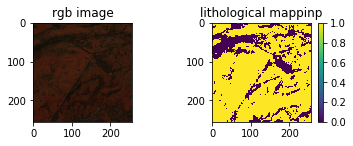

In [4]:
idx = 150
img = np.load(X_trn[idx])
lbl = np.load(Y_trn[idx])

img_rgb = np.transpose(img, [1,2,0])[:,:,::-1][:,:,-3:]
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('rgb image')
plt.subplot(222)
plt.imshow(np.argmax(lbl, axis=0))
plt.colorbar()
plt.title('lithological mappinp')

#### start to build and train Conv2D

In [5]:
conv = AdvSeg(dtype=dtype)

# build Conv2D
conv.build_AdvSegNet(adv_lr=1e-5, seg_lr=1e-3, verbose=True)

# now the tensorboard event file is saved in ./logs
# the training process, graph and statistics can be
# visualize by tensorboard

building Adversarial convolutional net ...
building Segmentation U-net ...
[64, 64, 64, 64]
[64, 64, 64]
summary of seg_model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 10) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 5824        image_input[0][0]                
__________________________________________________________________________________________________
alpha_dropout_1 (AlphaDropout)  (None, 256, 256, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 256, 256, 64) 36928       alpha_dropout_1[

In [6]:
trn_data = DataGenerator(X_trn, Y_trn, batch_size=10, dtype=dtype, intype=conv.model_type, pred_fn=conv.predict)
vld_data = DataGenerator(X_vld, Y_vld, batch_size=10, dtype=dtype, intype=conv.model_type, pred_fn=conv.predict)

#### check data generator

In [ ]:
trn_data.phase = 'AdversarialNet'
x, y = trn_data.getitem(1)
xx = x[0]
yy = x[1]
idx = 4
plt.subplot(221)
plt.imshow(2*xx[idx,:,:,:][:,:,::-1][:,:,-3:])
plt.title('img')
plt.subplot(222)
plt.imshow(np.argmax(yy[idx,:,:,:], axis=-1))
plt.colorbar()
plt.title('label')

In [ ]:
conv.fit_model_generator(trn_data, vld_data,
                         adv_epochs=10, adv_steps_per_epoch=10,
                         seg_epochs=100, seg_steps_per_epoch=10,
                         alt_num=2)

#### predict on test data

#### TO DO ####

#### visualize predicted Y

Text(0.5,1,'prediction')

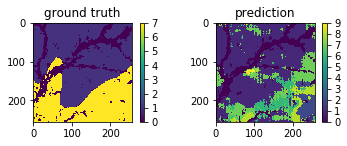

In [27]:
idx = 70
_pred = np.argmax(Y_preds[idx,:,:,:], axis=2)
_tst = np.argmax(yy[idx,:,:,:], axis=2)
plt.subplot(221)
plt.imshow(_tst)
plt.colorbar()
plt.title('ground truth')
plt.subplot(222)
plt.imshow(_pred)
plt.colorbar()
plt.title('prediction')

#### calculate the accuracy

In [28]:
acc_list = []
for i in range(yy.shape[0]):
    tmp_pred = np.argmax(Y_preds[i,:,:,:], axis=2)
    tmp_tst = np.argmax(yy[i,:,:,:], axis=2)
    acc_list.append(np.where(tmp_pred == tmp_tst)[0].shape[0]/(256*256))
print('mean accuracy on test data is {0}, std is {1}'.format(np.mean(acc_list), np.std(acc_list)))
print('max is {0}, min is {1}'.format(max(acc_list), min(acc_list)))

mean accuracy on test data is 0.5370923822576349, std is 0.21697654456103174
max is 0.9677886962890625, min is 0.0312347412109375
